# gatorAI Summer Camp 2024

In this first notebook, we're going to use Python to create a deep learning model that can take images of faces and output the emotion being expressed. 

The dataset we're going to use is the FER-2013 dataset, which contains 35,887 grayscale images of faces. Each image is 48x48 pixels and is labeled with one of seven emotions: anger, disgust, fear, happiness, sadness, surprise, or neutral.

To build our model, we'll use the Keras deep learning library, which provides a high-level interface for building and training neural networks. We'll start by loading the dataset and exploring the images, then we'll build and train a convolutional neural network (CNN) to classify the emotions in the images.

In [1]:
# Import the necessary libraries
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# Import the libraries for CNNs

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Import the libraries for the evaluation
from sklearn.metrics import classification_report, confusion_matrix


***********************************************************************
Load data:
  - Loading the dataset from: data/emotion_images/train.
  - Using a batch size of: 32.
  - Resizing input images to: (80, 80, 1).
***********************************************************************
Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


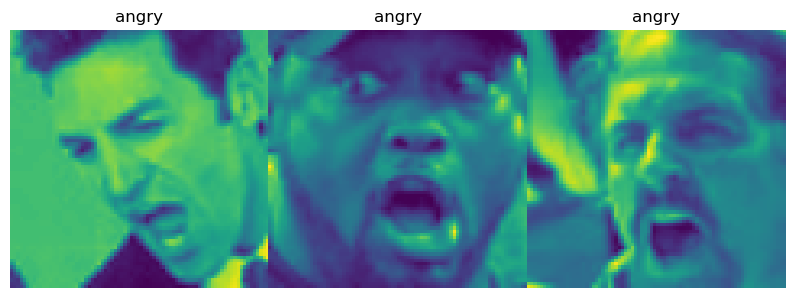

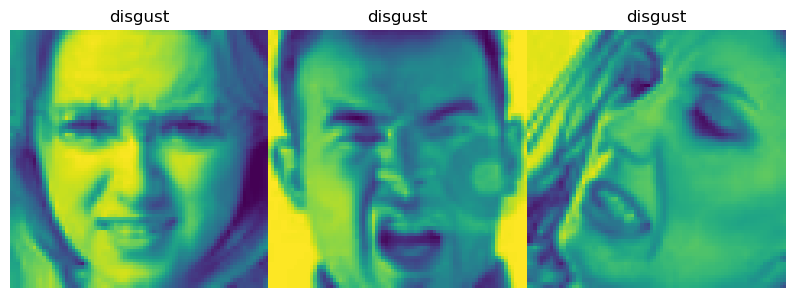

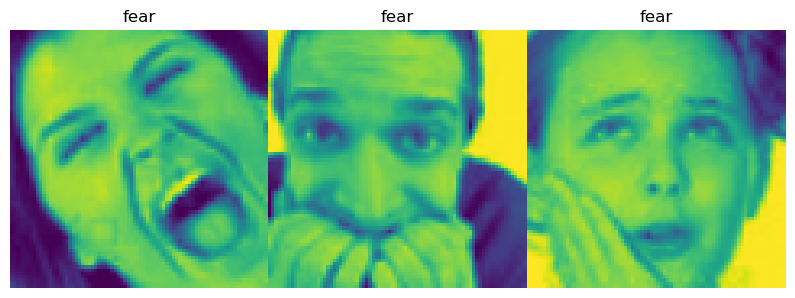

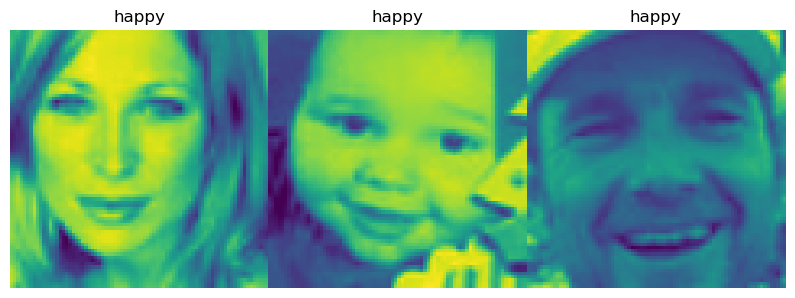

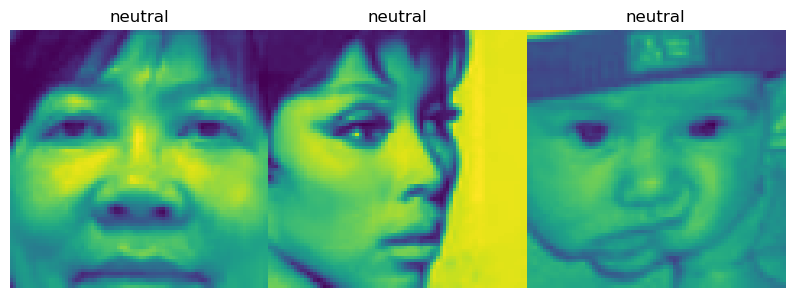

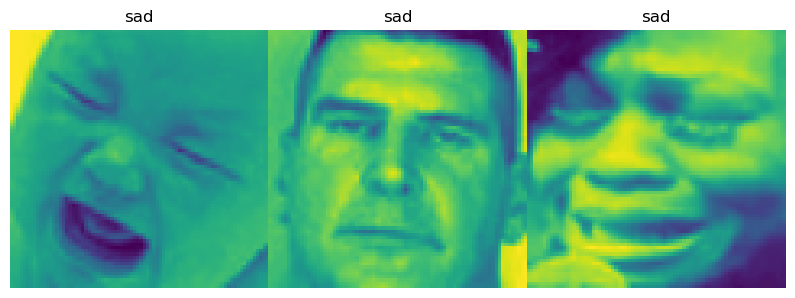

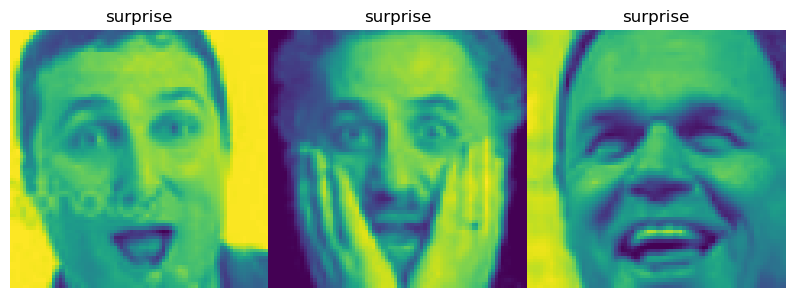

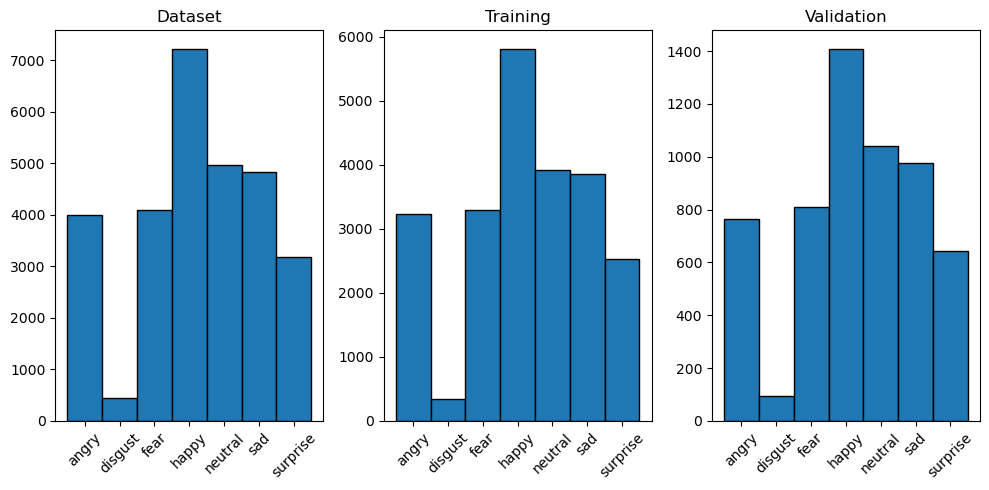

In [2]:
def load_display_data(path, batch_size=32, shape=(80, 80, 1), show_pictures=True, show_histogram=True):
    '''Takes a path, batch size, target shape for images and optionally whether to show sample images.
       Returns training and testing datasets
    '''
    print("***********************************************************************")
    print("Load data:")
    print(f"  - Loading the dataset from: {path}.")
    print(f"  - Using a batch size of: {batch_size}.")
    print(f"  - Resizing input images to: {shape}.")
    print("***********************************************************************")
    # Define the directory path
    directory_path = path
    
    # Define the batch size
    batch_size = batch_size
    
    # Define the image size using the 1st 2 elements of the shape parameter
    # We don't need the number of channels here, just the dimensions to use
    image_size = shape[:2]
    
    # Load the dataset
    X_train = tf.keras.preprocessing.image_dataset_from_directory(
        directory_path,
        batch_size=batch_size,
        image_size=image_size,
        validation_split=0.2,
        subset='training',
        seed=123,
        labels='inferred',
        label_mode='int',
        color_mode='grayscale'
    )
    
    X_val = tf.keras.preprocessing.image_dataset_from_directory(
        directory_path,
        batch_size=batch_size,
        image_size=image_size,
        validation_split=0.2,
        subset='validation',
        seed=123,
        labels='inferred',
        label_mode='int',
        color_mode='grayscale'
    )
    
    if show_pictures:
        # Get the class names
        class_names = X_train.class_names
        print(class_names)
    
        # Display up to 3 images from each of the categories
        class_images_dict = {class_name: [] for class_name in class_names}

        # Collect images for each class
        for images, labels in X_train:
            images = images.numpy()
            labels = labels.numpy()

            for i, class_name in enumerate(class_names):
                if len(class_images_dict[class_name]) < 3:
                    # Filter images of the current class
                    class_images = images[labels == i]
                    class_images_dict[class_name].extend(class_images[:3 - len(class_images_dict[class_name])])

            # Break if we have collected enough images for all classes
            if all(len(imgs) >= 3 for imgs in class_images_dict.values()):
                break

        # Display the collected images
        for class_name, class_images in class_images_dict.items():
            fig, axs = plt.subplots(1, 3, figsize=(10, 10))
            fig.subplots_adjust(wspace=0, hspace=30)  # Adjust the space between subplots

            for j in range(len(class_images)):
                ax = axs[j]
                ax.imshow(class_images[j].astype("uint8"))
                ax.set_title(class_name)
                ax.axis("off")
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                ax.set_aspect('equal')
            
            plt.show()

    if show_histogram:
        # Collect all labels for training and validation datasets
        train_labels = []
        for images, labels in X_train:
            train_labels.extend(labels.numpy())

        val_labels = []
        for images, labels in X_val:
            val_labels.extend(labels.numpy())

        # Display the class distribution for the entire dataset
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 3, 1)
        plt.title("Dataset")
        # Title for the total dataset
        plt.hist(train_labels+val_labels, bins=np.arange(len(class_names) + 1) - 0.5, edgecolor='black')
        plt.xticks(range(len(class_names)), labels=class_names, rotation=45)

        plt.subplot(1, 3, 2)
        plt.title("Training")
        plt.hist(train_labels, bins=np.arange(len(class_names) + 1) - 0.5, edgecolor='black')
        plt.xticks(range(len(class_names)), labels=class_names, rotation=45)

        plt.subplot(1, 3, 3)
        plt.title("Validation")
        plt.hist(val_labels, bins=np.arange(len(class_names) + 1) - 0.5, edgecolor='black')
        plt.xticks(range(len(class_names)), labels=class_names, rotation=45)

        plt.tight_layout()
        plt.show()

    return X_train, X_val

data_path = 'data/emotion_images/train'

X_train, X_val = load_display_data(data_path, batch_size=32, shape=(80, 80, 1), show_pictures=True, show_histogram=True)

In [3]:
# Define the CNN model architecture

def create_model(input_shape, num_classes, padding='same', activation='relu', dropout_rate=0.0):
    '''Takes the input shape and number of classes and returns a CNN model'''
    print("***********************************************************************")
    print("Create model:")
    print(f"  - Input shape: {input_shape}.")
    print(f"  - Number of classes: {num_classes}.")
    print("***********************************************************************")
    # Create the model
    model = Sequential([
        Conv2D(16, 3, padding=padding, activation=activation, input_shape=input_shape),
        MaxPooling2D(),
        Dropout(dropout_rate),
        Conv2D(32, 3, padding=padding, activation=activation),
        MaxPooling2D(),
        Dropout(dropout_rate),
        Conv2D(64, 3, padding=padding, activation=activation),
        MaxPooling2D(),
        Dropout(dropout_rate),
        Flatten(),
        Dense(128, activation=activation),
        Dense(num_classes, activation='softmax')
    ])
    # Visualize the model
    model.summary()

    return model

# Define our instance of the model

input_shape = (80, 80, 1)
num_classes = 7

model = create_model(input_shape, num_classes, padding='same', activation='relu')



***********************************************************************
Create model:
  - Input shape: (80, 80, 1).
  - Number of classes: 7.
***********************************************************************
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 80, 80, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 40, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 40, 40, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20,

In [4]:
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [5]:
# Train the model
history = model.fit(X_train, validation_data=X_val, epochs=10)

Epoch 1/10


c:\Users\i.lutticken\AppData\Local\anaconda3\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


718/718 [==============================] - 40s 55ms/step - loss: 2.0029 - accuracy: 0.3066 - val_loss: 1.5963 - val_accuracy: 0.3769
Epoch 2/10
718/718 [==============================] - 56s 78ms/step - loss: 1.5332 - accuracy: 0.4089 - val_loss: 1.4945 - val_accuracy: 0.4167
Epoch 3/10
718/718 [==============================] - 51s 71ms/step - loss: 1.4131 - accuracy: 0.4579 - val_loss: 1.4995 - val_accuracy: 0.4254
Epoch 4/10
493/718 [===================>..........] - ETA: 28s - loss: 1.3060 - accuracy: 0.5032

In [ ]:
# Evaluate the model
print("***********************************************************************")
print("Accuracy and Loss per Epoch:")
print("***********************************************************************")
loss, accuracy = model.evaluate(X_val)
print(f"Loss: {loss}, Accuracy: {accuracy}")

# Plot the training history
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title("Loss")
plt.show()

# Define a function to plot the confusion matrix
def plot_confusion_matrix(model, dataset):
    print("***********************************************************************")
    print("Confusion matrix:")
    print("***********************************************************************")
    
    # Get the true labels
    y_true = []
    for images, labels in dataset:
        y_true.extend(labels.numpy())

    # Get the predicted labels
    y_pred = model.predict(dataset)
    y_pred = np.argmax(y_pred, axis=1)

    # Get the class names
    class_names = dataset.class_names

    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(15, 15))
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(range(len(class_names)), labels=class_names, rotation=45)
    plt.yticks(range(len(class_names)), labels=class_names)

    # Annotate each cell with the numeric value
    thresh = cm.max() / 2
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.show()

# Example usage (assuming X_val is your validation dataset)
plot_confusion_matrix(model, X_val)